# EGN6217 P2

[Hugging Face Wav2Vec2](https://huggingface.co/docs/transformers/en/model_doc/wav2vec2)

[Hugging Face Wav2Vec2 Tutorial](https://huggingface.co/docs/transformers/tasks/asr)

[LibriSpeech ASR Corpus](https://www.openslr.org/12)

In [1]:
!pip install jiwer
import torch
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
from IPython.display import Audio, display
import random
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import jiwer
import gradio as gr
import librosa

# Wave2VecProcessor = audio preprocessing + tokenization
# Wav2Vec2ForCTC = connectionist temporal classification, the speech-to-text model

Defaulting to user installation because normal site-packages is not writeable


## Data Loading

In [2]:
def read_librispeech_dir(path):

    x = []
    t = []

    # for all sub-dirs
    i = 0
    for root, _, files in os.walk(path):
    
        # get current dir flac paths
        flacs = [f for f in files if f.endswith(".flac")]
    
        # get current dir transcript path
        transcript = None
        for file in files:
            if file.strip().endswith("trans.txt"):
                transcript = os.path.join(root, file)
                break

        # error checking :)
        if flacs == [] and transcript == None:
            continue
        elif (flacs == [] and transcript != None) or (flacs != [] and transcript == None):
            raise ValueError("ERROR: directory is missing either flac audio files or transcript file")
    
        # build {flac: transcript} dictionary mapping from transcript
        transcript_dict = {}
        with open(transcript, "r") as f:
            for line in f:
                parts = line.strip().split(" ", 1) # split "1234-123456-0000 THIS IS EXAMPLE TEXT"
                transcript_dict[parts[0]] = parts[1]

        # populate x and t with dictionary mapping
        for flac_file in flacs:
            flac_path = os.path.join(root, flac_file)
            flac_id = flac_file.replace(".flac", "") # pull out of "1234-123456-0000.flac"

            # get flac audio and corresponding transcript
            audio, sample_rate = torchaudio.load(flac_path)
            if flac_id in transcript_dict:
                transcript = transcript_dict[flac_id]
            else:
                raise ValueError("ERROR: flac file does not have a corresponing transcript line")

            x.append(audio)
            t.append(transcript)

            if i == 0:
                print(f"Audio sample rate: {sample_rate}")
                i += 1
            
    return x, t

In [3]:
# load in data

train_root = "/kaggle/input/librispeech/LibriSpeech/dev-clean/"
test_root = "/kaggle/input/librispeech/LibriSpeech/test-clean/"

x_train, t_train = read_librispeech_dir(train_root)
x_test, t_test = read_librispeech_dir(test_root)

print(f"Train: {len(x_train)}, {len(t_train)}")
print(f"Test: {len(x_test)}, {len(t_test)}")

Audio sample rate: 16000
Audio sample rate: 16000
Train: 2703, 2703
Test: 2620, 2620


In [4]:
# grab subset of data for faster training
x_train = x_train[:1000]
t_train = t_train[:1000]
x_test = x_test[:1000]
t_test = t_test[:1000]

In [5]:
# display example

idx = random.randint(0, 100)
audio = x_train[idx].numpy().squeeze()
display(Audio(audio, rate=16000))

print("Transcript:", t_train[idx])

Transcript: THE QUEEN GAZED UPON OUR FRIENDS WITH EVIDENT INTEREST


## Data Preprocessing

In [6]:
# create torch Datasets

class LibrispeechDataset(Dataset):
    def __init__(self, x, t):
        self.x = x
        self.t = t
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.t[idx]

train_dataset = LibrispeechDataset(x_train, t_train)
test_dataset = LibrispeechDataset(x_test, t_test)

In [28]:
# save torch Datasets
torch.save(train_dataset, "/kaggle/working/train_dataset.pth")
torch.save(test_dataset, "/kaggle/working/test_dataset.pth")

In [7]:
# create torch DataLoaders

# applies batch-wise preprocessing when data is accessed
def collate_wav2vec2(batch):    
    # separate audio and transcripts from batch
    audio = [item[0][0].squeeze().numpy() for item in batch]  # remove extra list wrapping
    transcripts = [item[1] for item in batch]
    # preprocess audio and transcripts
    audio = processor(audio, padding="longest", sampling_rate=16000, return_attention_mask=True, return_tensors="pt")
    transcripts = processor.tokenizer(transcripts, padding="longest",return_tensors="pt")
    return audio, transcripts

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h", do_normalize=True)
train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_wav2vec2)
test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_wav2vec2)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Train batches: 250
Test batches: 250


In [8]:
# display batch info
i = 0
for audios, transcripts in train_loader:
    if i > 1:
        break
    print(f"BATCH {i+1}")
    print(f"Audio lengths: {len(audios.input_values[0])}, {len(audios.input_values[1])}, {len(audios.input_values[2])}, ...")
    print(f"Transcript lengths: {len(transcripts.input_ids[0])}, {len(transcripts.input_ids[1])}, {len(transcripts.input_ids[2])}, ...\n")
    i +=1 

BATCH 1
Audio lengths: 144800, 144800, 144800, ...
Transcript lengths: 132, 132, 132, ...

BATCH 2
Audio lengths: 254800, 254800, 254800, ...
Transcript lengths: 260, 260, 260, ...



In [9]:
# display examples
for audios, transcripts in train_loader:
    print(f"Audio examples:\n{audios}")
    print(f"\nTranscript examples:\n{transcripts}")
    break

Audio examples:
{'input_values': tensor([[-0.0084, -0.0084, -0.0084,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0233,  0.0051,  0.0487,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0122, -0.0108, -0.0122,  ...,  0.0144,  0.0505,  0.0553],
        [-0.0024,  0.0316,  0.0109,  ...,  0.0000,  0.0000,  0.0000]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], dtype=torch.int32)}

Transcript examples:
{'input_ids': tensor([[10,  9,  4,  6, 11,  7,  6,  4, 19,  7, 12,  5,  4, 12,  7, 10, 14,  4,
         24, 16,  6,  6,  8,  9,  4, 24, 13, 10, 21, 11,  6,  4, 22,  8, 16, 27,
         13,  5,  4,  5,  9,  6, 10,  6, 15,  5, 14,  4,  6,  8,  4,  6, 11,  5,
          4, 24,  5, 12,  6,  4,  6, 11,  5, 13,  5,  4, 10, 12,  4,  6,  8,  4,
         23,  7, 22,  4, 20,  8, 13,  4, 22,  8, 16, 13,  4,  6, 13,  8, 16, 24,
         15,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 

## Training

In [ ]:
def train(model, train_loader, processor, loss_fn, optimizer, num_epochs):
    warnings.filterwarnings('ignore')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_fn.to(device)

    LC_train_loss = []
    LC_train_wer = []
    
    print(f"Beginning training on {device}...")

    # for each epoch
    for epoch in range(num_epochs):
        
        model.train(True)            # enable dropout, batch normalization, etc.
        torch.set_grad_enabled(True) # enable gradient calculation and storage
        train_loss = 0.0
        train_wer = 0.0
        num_samples = 0

        # for each batch
        for audios, transcripts in train_loader:
            
            audios_att_masks = audios["attention_mask"].to(device)
            audios = audios["input_values"].to(device)
            # transcripts_att_masks = transcripts["attention_mask"].to(device) # not used in Wav2Vec2ForCTC
            transcripts = transcripts["input_ids"].to(device)

            transcripts[transcripts == processor.tokenizer.pad_token_id] = -100 # ignore padding

            # forward propagation
            outputs = model(audios, attention_mask=audios_att_masks, labels=transcripts)
            loss = outputs.loss
            train_loss += loss.item() # batch avg
            
            # back propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            del audios_att_masks; del audios

            # compute WER
            with torch.no_grad():
                # decode predictions
                pred_ids = torch.argmax(outputs.logits, dim=-1)
                pred_transcripts = processor.batch_decode(pred_ids, skip_special_tokens=True, group_tokens=True)
                # decode ground truth transcripts
                transcripts[transcripts == -100] = processor.tokenizer.pad_token_id  # re-convert padding
                true_transcripts = processor.batch_decode(transcripts, skip_special_tokens=True)
                # compute sample WERs
                wers = [jiwer.wer([true_transcript], [pred_transcript]) for true_transcript, pred_transcript in zip(true_transcripts, pred_transcripts)]
                train_wer += sum(wers)
                num_samples += len(true_transcripts)

            del transcripts; del outputs; del loss; del pred_ids; del pred_transcripts; del true_transcripts; del wers
            # gc.collect()
            # torch.cuda.empty_cache()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_wer = train_wer / num_samples
        LC_train_loss.append(avg_train_loss)
        LC_train_wer.append(avg_train_wer)
        print(f'EPOCH {epoch+1:3d} || AVG TRAIN LOSS: {avg_train_loss:.4f} || AVG TRAIN WER: {avg_train_wer:.4f}')

        # print(torch.cuda.memory_summary(device=device, abbreviated=True))

    model.to("cpu")
    loss_fn.to("cpu")
    return model, LC_train_loss, LC_train_wer

In [ ]:
# train

warnings.filterwarnings('ignore')

wav2vec2_model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h",
    vocab_size=len(processor.tokenizer),
    pad_token_id=processor.tokenizer.pad_token_id,
    ctc_loss_reduction="mean"
)

loss_fn = torch.nn.CTCLoss(blank=processor.tokenizer.pad_token_id)
optimizer = optim.AdamW(wav2vec2_model.parameters(), lr=1e-5)

wav2vec2_model, LC_train_loss, LC_train_wer = train(wav2vec2_model, train_loader, processor, loss_fn, optimizer, 10)
wav2vec2_model.save_pretrained("wav2vec2_model")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Beginning training on cuda...
EPOCH   1 || AVG TRAIN LOSS: 0.2588 || AVG TRAIN WER: 0.2439
EPOCH   2 || AVG TRAIN LOSS: 0.1711 || AVG TRAIN WER: 0.1896
EPOCH   3 || AVG TRAIN LOSS: 0.1364 || AVG TRAIN WER: 0.1639
EPOCH   4 || AVG TRAIN LOSS: 0.1349 || AVG TRAIN WER: 0.1600
EPOCH   5 || AVG TRAIN LOSS: 0.1309 || AVG TRAIN WER: 0.1490
EPOCH   6 || AVG TRAIN LOSS: 0.1119 || AVG TRAIN WER: 0.1244
EPOCH   7 || AVG TRAIN LOSS: 0.1011 || AVG TRAIN WER: 0.1083
EPOCH   8 || AVG TRAIN LOSS: 0.1022 || AVG TRAIN WER: 0.1063
EPOCH   9 || AVG TRAIN LOSS: 0.1096 || AVG TRAIN WER: 0.1065
EPOCH  10 || AVG TRAIN LOSS: 0.1024 || AVG TRAIN WER: 0.1010


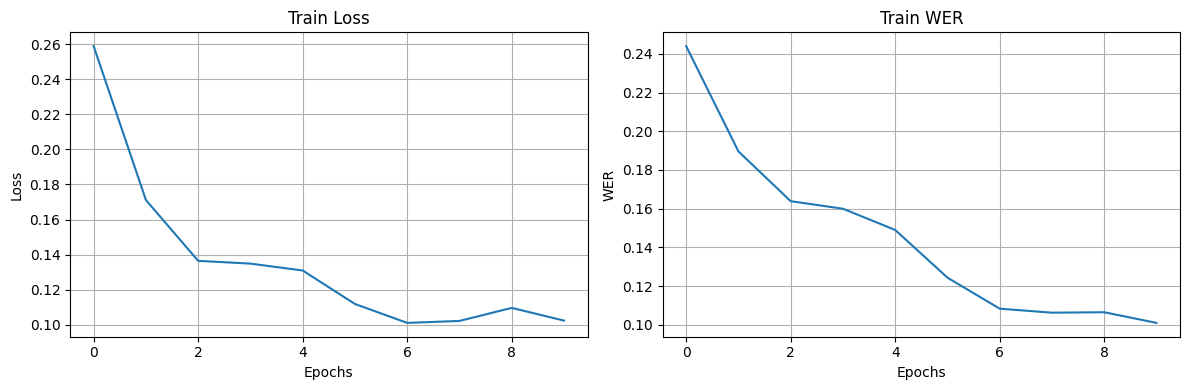

In [25]:
# plot LCs

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(LC_train_loss)
axes[0].set_title("Train Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].grid(True)

axes[1].plot(LC_train_wer)
axes[1].set_title("Train WER")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("WER")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Testing

In [ ]:
# # re-setup environment

# # processor, model, and loss function
# processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h", do_normalize=True)
# wav2vec2_model = Wav2Vec2ForCTC.from_pretrained("wav2vec2_model")
# loss_fn = torch.nn.CTCLoss(blank=processor.tokenizer.pad_token_id)

# # train and test Datasets
# class LibrispeechDataset(Dataset):
#     def __init__(self, x, t):
#         self.x = x
#         self.t = t
#     def __len__(self):
#         return len(self.x)
#     def __getitem__(self, idx):
#         return self.x[idx], self.t[idx]
# torch.serialization.add_safe_globals([LibrispeechDataset]) # prevent error
# train_dataset = torch.load("train_dataset.pth")
# test_dataset = torch.load("test_dataset.pth")

# # train and test DataLoaders
# def collate_wav2vec2(batch): # applies batch-wise preprocessing when data is accessed   
#     # separate audio and transcripts from batch
#     audio = [item[0][0].squeeze().numpy() for item in batch]  # remove extra list wrapping
#     transcripts = [item[1] for item in batch]
#     # preprocess audio and transcripts
#     audio = processor(audio, padding="longest", sampling_rate=16000, return_attention_mask=True, return_tensors="pt")
#     transcripts = processor.tokenizer(transcripts, padding="longest",return_tensors="pt")
#     return audio, transcripts
# train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_wav2vec2)
# test_loader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_wav2vec2)

In [41]:
def test(model, test_loader, processor, loss_fn):
    warnings.filterwarnings('ignore')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    loss_fn.to(device)
    
    print(f"Beginning testing on {device}...\n")
        
    model.eval()                  # disable dropout, batch normalization, etc.
    torch.set_grad_enabled(False) # disable gradient calculation and storage
    test_loss = 0.0
    test_wer = 0.0
    num_samples = 0
    ex_iter = 0

    # for each batch
    for audios, transcripts in test_loader:
        
        audios_att_masks = audios["attention_mask"].to(device)
        audios = audios["input_values"].to(device)
        # transcripts_att_masks = transcripts["attention_mask"].to(device) # not used in Wav2Vec2ForCTC
        transcripts = transcripts["input_ids"].to(device)

        transcripts[transcripts == processor.tokenizer.pad_token_id] = -100 # ignore padding

        # forward propagation
        outputs = model(audios, attention_mask=audios_att_masks, labels=transcripts)
        loss = outputs.loss
        test_loss += loss.item() # batch avg

        del audios_att_masks; del audios

        # compute WER
        with torch.no_grad():
            # decode predictions
            pred_ids = torch.argmax(outputs.logits, dim=-1)
            pred_transcripts = processor.batch_decode(pred_ids, skip_special_tokens=True, group_tokens=True)
            # decode ground truth transcripts
            transcripts[transcripts == -100] = processor.tokenizer.pad_token_id  # re-convert padding
            true_transcripts = processor.batch_decode(transcripts, skip_special_tokens=True)
            # print first 5 pred and true transcripts
            if ex_iter < 5:
                print(f"Pred {ex_iter+1}: {pred_transcripts[0]}")
                print(f"True {ex_iter+1}: {true_transcripts[0]}")
                ex_iter += 1
            # compute sample WERs
            wers = [jiwer.wer([true_transcript], [pred_transcript]) for true_transcript, pred_transcript in zip(true_transcripts, pred_transcripts)]
            test_wer += sum(wers)
            num_samples += len(true_transcripts)

        del transcripts; del outputs; del loss; del pred_ids; del pred_transcripts; del true_transcripts; del wers
        # gc.collect()
        # torch.cuda.empty_cache()

    avg_test_loss = test_loss / len(test_loader)
    avg_test_wer = test_wer / num_samples
    print(f'\nAVG TEST LOSS: {avg_test_loss:.4f} || AVG TEST WER: {avg_test_wer:.4f}')

    # print(torch.cuda.memory_summary(device=device, abbreviated=True))

    model.to("cpu")
    loss_fn.to("cpu")

In [42]:
test(wav2vec2_model, test_loader, processor, loss_fn)

Beginning testing on cuda...

Pred 1: DO WE REALY KNOW THE MOUNTEN WEL WHEN WE ARE NOT ACQUAINTED WITH THE CAVERN
True 1: DO WE REALY KNOW THE MOUNTAIN WEL WHEN WE ARE NOT ACQUAINTED WITH THE CAVERN
Pred 2: TO KEP A FLOAT AND TO RESCUE FROM OBLIVION TO HOLD ABOVE THE GULF WERE IT BUT A FRAGMENT OF SOME LANGUAGE WHICH MEN HAS SPOKEN AND WHICH WOULD OTHERWISE BE LOST THAT IS TO SAY ONE OF THE ELEMENTS GOD OR BAD OF WHICH CIVILISATION IS COMPOSED OR BY WHICH IT IS COMPLICATED TO EXTEND THE RECORDS OF SOCIAL OBSERVATION IS TO SERVE CIVILIATION ITSELF
True 2: TO KEP AFLOAT AND TO RESCUE FROM OBLIVION TO HOLD ABOVE THE GULF WERE IT BUT A FRAGMENT OF SOME LANGUAGE WHICH MAN HAS SPOKEN AND WHICH WOULD OTHERWISE BE LOST THAT IS TO SAY ONE OF THE ELEMENTS GOD OR BAD OF WHICH CIVILIZATION IS COMPOSED OR BY WHICH IT IS COMPLICATED TO EXTEND THE RECORDS OF SOCIAL OBSERVATION IS TO SERVE CIVILIZATION ITSELF
Pred 3: WHY SHOULD ONE NOT EXPLORE EVERYTHING AND STUDY EVERYTHING
True 3: WHY SHOULD ONE NOT